In [1]:
import os
import glob
import pandas as pd
import numpy  as np

from invisible_cities.core.system_of_units import kg, dalton, year, mBq
from invisible_cities.core.configure       import read_config_file
from invisible_cities.evm.mixer            import get_file_number
from invisible_cities.evm.mixer            import Event_Mixer, _check_enough_nevents
from invisible_cities.evm.mixer            import get_mixer_nevents, get_reco_and_sim_nevents

from invisible_cities.io.dst_io            import load_dst, load_dsts

%matplotlib ipympl
import matplotlib.pyplot as plt

### compute IC processing efficiencies

In [2]:
inpath   = os.path.expandvars("$HOME/NEXT/DATA/production/{isotope}/{g4volume}/prod/isaura/*.h5")
isotopes = ["208Tl", "214Bi", "0nubb", "2nubb"]

ic_efficiencies       = "efficiencies_ic.csv"
compute_efficiencies  = False

In [3]:
if compute_efficiencies:
    components = []
    for isotope in isotopes:
        g4volumes = os.listdir(os.path.dirname(inpath).split("{g4volume}")[0].format(isotope=isotope))
        components += list(zip(g4volumes, [isotope]*len(g4volumes)))
    
    #compute
    efficiencies_df = get_reco_and_sim_nevents(inpath, components)
    
    #save
    efficiencies_df.to_csv(ic_efficiencies, index=False)

In [4]:
# # simulated exposures

# from invisible_cities.database import load_db
# act_df, mceff_df = load_db.RadioactivityData("next100")

# index = ["G4Volume", "Isotope"]
# eff_df   = efficiencies_df.set_index(index)
# act_df   =          act_df.set_index(index)
# mceff_df =        mceff_df.set_index(index)

# eff_df["exposure"] = ((eff_df.nsim/(mceff_df.MCEfficiency*act_df.TotalActivity * mBq))/year)

In [5]:
detector_db = "next100"
outpath     = os.path.expandvars("$PWD/mixer/mixer_{file_number}.h5")

xenon_mass  = 100. * kg
enrichment  = 0.9
exposure    = 20. * year

T12_0nubb   = 1e25 * year
verbosity   = 1
nevents_per_file = 1e5

In [6]:
T12_2nubb = 2.165e+21 * year

# compute initial number of 136Xe isotopes
assert (0. <= enrichment) & (enrichment <= 1.)
N0 = enrichment*(xenon_mass/(136. * dalton))

# get event df with (g4volume, isotope, nevts)
nevent_df = get_mixer_nevents(exposure, detector_db, isotopes)

# get number of decays of signal-like events
if "0nubb" in isotopes:
    if not T12_0nubb:
        raise Exception("0nubb half-life (T12_0nubb) is not provided")
    nevts = N0 * (np.log(2)/T12_0nubb) * exposure
    nevent_df.loc[len(nevent_df)] = ("ACTIVE", "0nubb", nevts)

if "2nubb" in isotopes:
    nevts = N0 * (np.log(2)/T12_2nubb) * exposure
    nevent_df.loc[len(nevent_df)] = ("ACTIVE", "2nubb", nevts)

# load processing efficiencies
eff_df = pd.read_csv(os.path.expandvars(ic_efficiencies))

In [7]:
# add reconstruction efficiency and poissonize
nevent_df.nevts = nevent_df.nevts * (eff_df.nreco/eff_df.nsim)
nevent_df.nevts = np.random.poisson(nevent_df.nevts)

In [8]:
# run mixer
mixer = Event_Mixer(inpath, outpath, nevent_df, nevents_per_file, verbosity)
mixer.run()

>> Initializing mixer...
 ------------------------
 Number of events to mix:
 ------------------------
                          nevts
Isotope G4Volume               
208Tl   ANODE_RING           45
214Bi   ANODE_RING           21
208Tl   CATHODE_RING         29
214Bi   CATHODE_RING         42
208Tl   DB_PLUG              49
214Bi   DB_PLUG               3
208Tl   EP_COPPER_PLATE     849
214Bi   EP_COPPER_PLATE     138
208Tl   FIELD_RING         6126
214Bi   FIELD_RING          282
208Tl   GATE_RING            53
214Bi   GATE_RING            29
208Tl   HDPE_TUBE            70
214Bi   HDPE_TUBE            23
208Tl   ICS               19167
214Bi   ICS                 148
208Tl   LIGHT_TUBE         2428
214Bi   LIGHT_TUBE           69
208Tl   OPTICAL_PAD         339
214Bi   OPTICAL_PAD          23
208Tl   PEDESTAL             37
214Bi   PEDESTAL              2
208Tl   PMT                 421
214Bi   PMT                  44
208Tl   PMT_BASE            844
214Bi   PMT_BASE             29
2

In [9]:
filenames = glob.glob(outpath.format(file_number="*"))
tracks = load_dsts(filenames, "Tracking", "Tracks").set_index(["event", "Isotope", "G4Volume"])

In [12]:
event_energy = tracks.groupby(level=[0, 1, 2]).energy.sum()

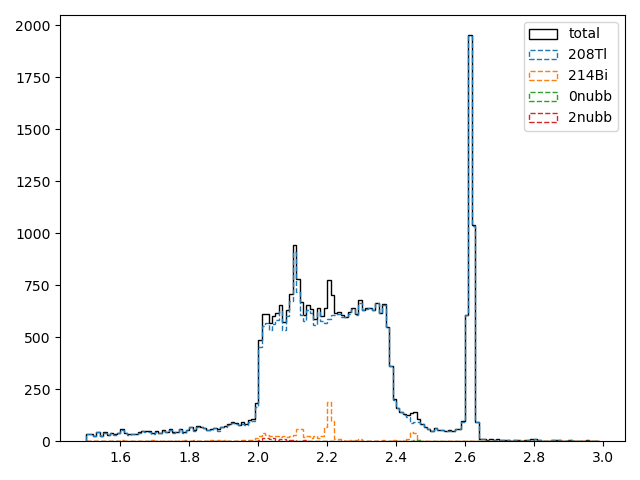

In [18]:
plt.figure()

bins = np.arange(1.5, 3, 0.01)

plt.hist(event_energy, bins=bins, histtype="step", color="k", label="total")

for isotope in isotopes:
    plt.hist( event_energy.loc[(slice(None), isotope,)]
            , bins=bins, histtype="step", linestyle="--", label=isotope)
    
plt.legend()
plt.tight_layout()